In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 
import koreanize_matplotlib

In [2]:
train = pd.read_csv("./train.csv", parse_dates=["일시"])
submit = pd.read_csv("./sample_submission.csv")

In [3]:
type(train["일시"][1])

pandas._libs.tslibs.timestamps.Timestamp

In [4]:
# '일시'를 인덱스로 설정하고 빈도를 'D'로 설정
train = train.set_index('일시')

In [5]:
train.isnull().sum()

최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

In [6]:
condition1 = train['최고기온'].isna()
condition2 = train['최저기온'].isna()
condition3 = train['일교차'].isna()

train[condition1 | condition2 | condition3]

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,
1967-02-19,NaN,NaN,NaN,NaN,62.0,1.8,9.5,NaN,93.1,-1.7
1973-10-16,NaN,NaN,NaN,0.4,74.0,1.8,3.5,9.24,29.7,12.3
2017-10-12,NaN,8.8,NaN,NaN,71.0,2.0,NaN,2.23,0.0,11.4
2022-08-08,28.4,NaN,NaN,129.6,91.6,3.3,NaN,NaN,0.0,26.8


In [7]:
# 최고기온과 최저기온의 결측값을 선형 보간법으로 채우기
train['최고기온'] = train['최고기온'].interpolate(method='linear')
train['최저기온'] = train['최저기온'].interpolate(method='linear')

# '일교차'가 결측인 경우에 한하여 최고기온과 최저기온의 차로 '일교차' 계산
train.loc[train['일교차'].isna(), '일교차'] = train['최고기온'] - train['최저기온']

# 결측값 대체 확인
display(train[condition1 | condition2 | condition3])
print(train.isnull().sum())

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,
1967-02-19,3.25,-6.15,9.40,NaN,62.0,1.8,9.5,NaN,93.1,-1.7
1973-10-16,17.00,5.65,11.35,0.4,74.0,1.8,3.5,9.24,29.7,12.3
2017-10-12,20.30,8.80,11.50,NaN,71.0,2.0,NaN,2.23,0.0,11.4
2022-08-08,28.40,24.60,3.80,129.6,91.6,3.3,NaN,NaN,0.0,26.8


최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64


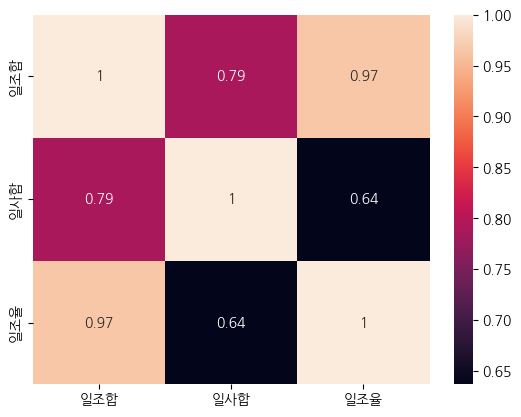

In [8]:
import seaborn as sns
sun_data = train[['일조합', '일사합', '일조율']]

sns.heatmap(sun_data.corr(), annot = True)
plt.show()

In [9]:
train[(train['일조합'].isna()) & (train['일조율'].isna())]

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,


In [10]:
from sklearn.linear_model import LinearRegression


# 일조율 결측값을 채우기 위한 모델 정의
fill_rate_model = LinearRegression()

# 결측값이 없는 데이터로 모델을 학습
not_null_data = train[(train['일조합'].notna()) & (train['일조율'].notna())]

# 독립변수로 '일조합'을 사용
X = not_null_data[['일조합']]
y = not_null_data['일조율']
fill_rate_model.fit(X, y)

# 일조율 결측값을 예측하여 채우기
is_null_일조율 = train['일조율'].isna()
train.loc[is_null_일조율, '일조율'] = fill_rate_model.predict(train.loc[is_null_일조율, ['일조합']])



# 독립변수로 '일조율'을 사용
X = train[['일조율']] 
y = train['일조합'].dropna()

# 일조합 결측값을 채우기 위한 모델 정의
fill_sum_model = LinearRegression()
fill_sum_model.fit(X[~train['일조합'].isna()], y)

# 일조합 결측값을 예측하여 채우기
is_null_일조합 = train['일조합'].isna()
train.loc[is_null_일조합, '일조합'] = fill_sum_model.predict(train.loc[is_null_일조합, ['일조율']])

# 모든 결측값이 채워졌는지 확인
train.isnull().sum()

최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        4
일조합         0
일사합      4862
일조율         0
평균기온        0
dtype: int64

In [11]:
# 일사합 결측값을 채우기 위한 모델 정의
fill_irradiance_model = LinearRegression()

# 결측값이 없는 데이터로 모델을 학습
not_null_irradiance_data = train[(train['일조합'].notna()) & (train['일사합'].notna())]

# 독립변수로 '일조합'을 사용
X_irradiance = not_null_irradiance_data[['일조합']]
y_irradiance = not_null_irradiance_data['일사합']
fill_irradiance_model.fit(X_irradiance, y_irradiance)

# 일사합 결측값을 예측하여 채우기
is_null_일사합 = train['일사합'].isna()
train.loc[is_null_일사합, '일사합'] = fill_irradiance_model.predict(train.loc[is_null_일사합, ['일조합']])

# 모든 결측값이 채워졌는지 확인
train.isnull().sum()

최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        4
일조합         0
일사합         0
일조율         0
평균기온        0
dtype: int64

In [12]:
# 일자에서 월 추출
train['월'] = train.index.month

# 각 월별 평균풍속의 중앙값 계산
median_wind_speed_per_month = train.groupby('월')['평균풍속'].median()

# 각 월별로 평균풍속 결측값을 해당 월의 중앙값으로 대체
for month, median in median_wind_speed_per_month.items():
    train.loc[(train['월'] == month) & (train['평균풍속'].isna()), '평균풍속'] = median

# 더 이상 필요하지 않은 '월' 컬럼 삭제
train.drop('월', axis=1, inplace=True)

# 결측값이 잘 대체되었는지 확인
train.isnull().sum()

최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        0
일조합         0
일사합         0
일조율         0
평균기온        0
dtype: int64

In [13]:
train['강수량'].fillna(method='bfill', inplace = True)
train.isnull().sum()

최고기온    0
최저기온    0
일교차     0
강수량     0
평균습도    0
평균풍속    0
일조합     0
일사합     0
일조율     0
평균기온    0
dtype: int64

In [14]:
train.to_csv('preprocessing_train.csv', index = True)